<a href="https://colab.research.google.com/github/jyotidabass/UNet-tongue-image-extraction/blob/main/UNet_Tongue_image_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!/usr/local/cuda/bin/nvcc --version
!git clone https://github.com/shreyas-bk/U-2-Net
%cd /content/U-2-Net
print('making images directory')
!mkdir images
print('making results directory')
!mkdir results
print('importing...')
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2
from google.colab.patches import cv2_imshow
print('Done!')

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Cloning into 'U-2-Net'...
remote: Enumerating objects: 520, done.
remote: Total 520 (delta 0), reused 0 (delta 0), pack-reused 520
Receiving objects: 100% (520/520), 12.39 MiB | 32.19 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/U-2-Net
making images directory
making results directory
importing...
Done!


In [2]:
%cd /content/U-2-Net/images
uploaded = files.upload()
%cd /content/U-2-Net

/content/U-2-Net/images


Saving IMG_20211110_112018 - Pranay Chadha.jpg to IMG_20211110_112018 - Pranay Chadha.jpg
/content/U-2-Net


['/content/U-2-Net/images/IMG_20211110_112018 - Pranay Chadha.jpg']
inferencing: IMG_20211110_112018 - Pranay Chadha.jpg

INPUT                                    BACKGROUND REMOVED                                      SALIENT MAP



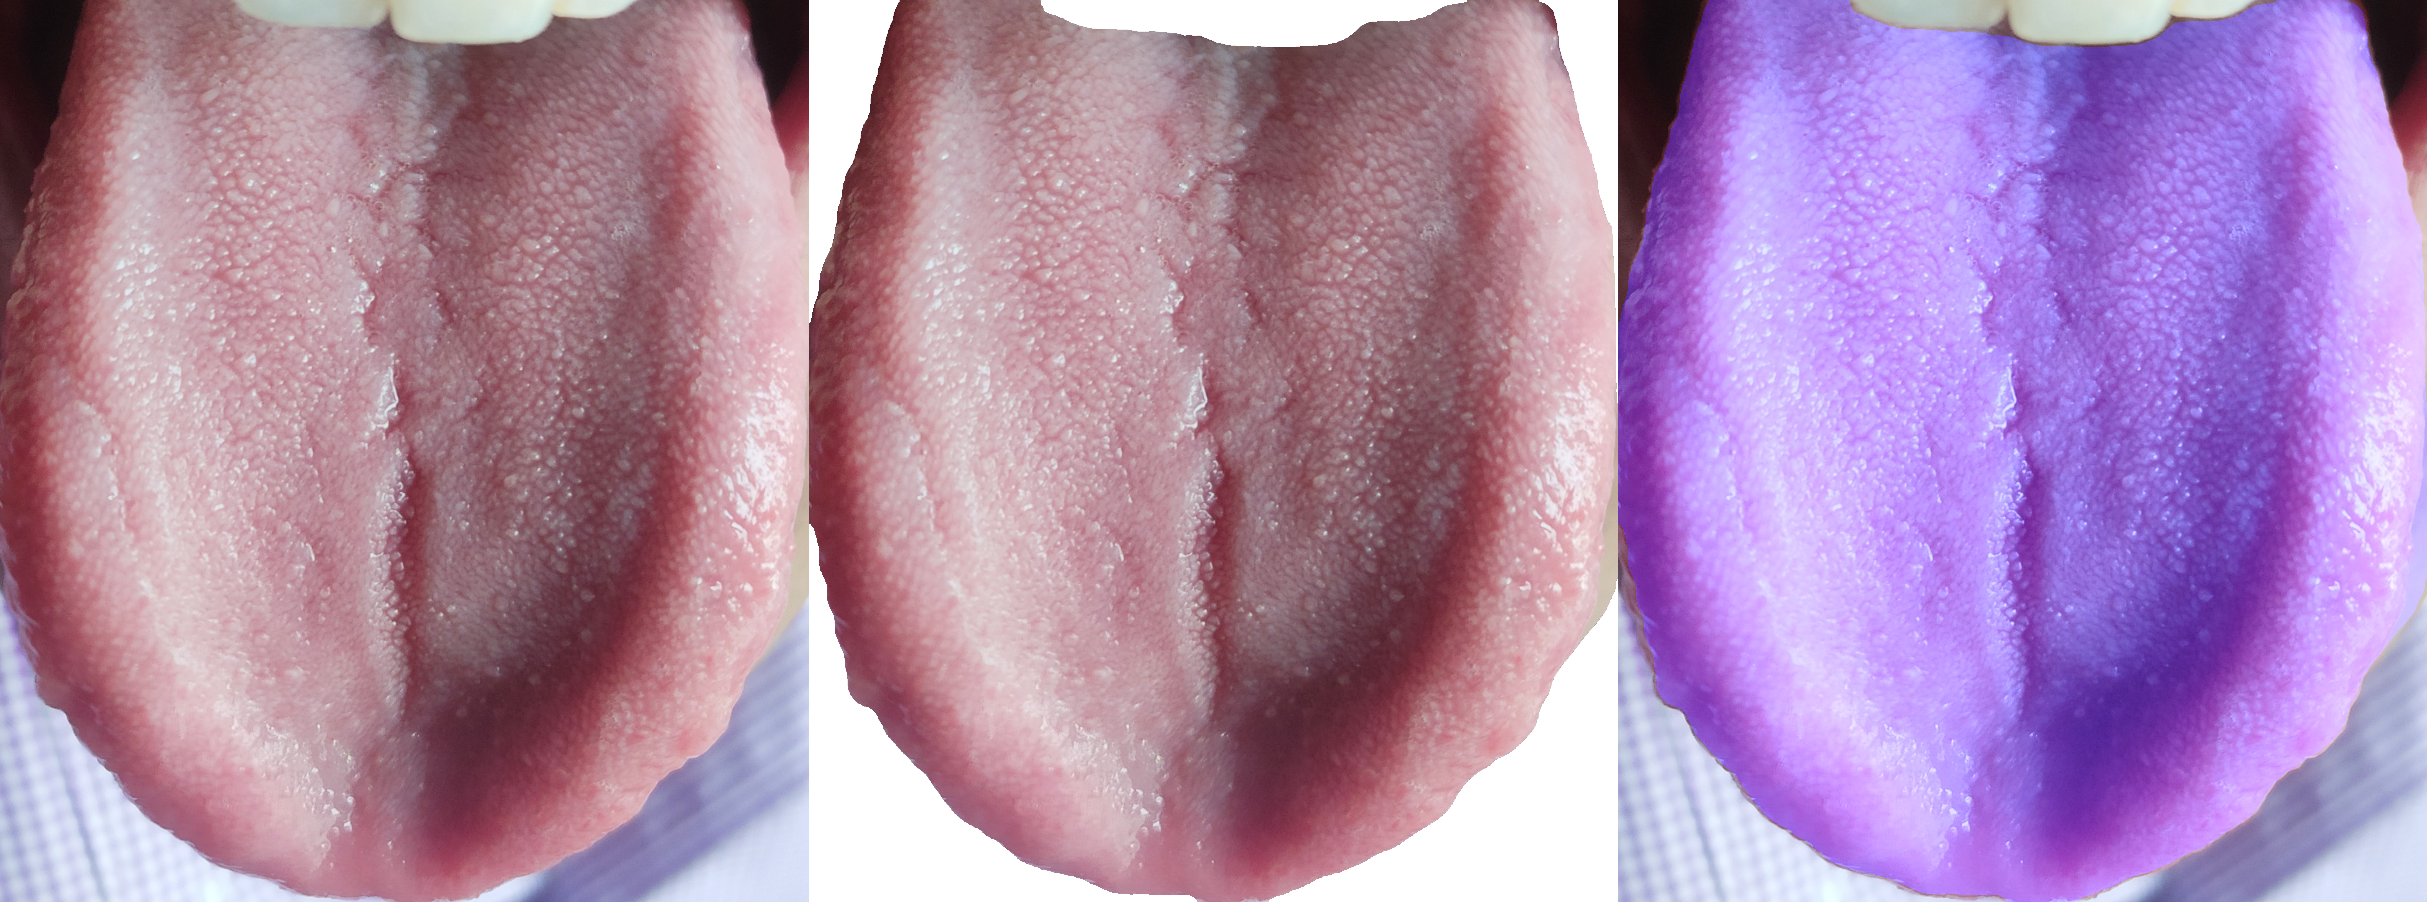

In [6]:
!python -W ignore u2net_test.py

image_dir = os.path.join(os.getcwd(), 'images')
names = [name[:-4] for name in os.listdir(image_dir)]
THRESHOLD = 0.9
RESCALE = 255
LAYER = 2
COLOR = (0, 0, 0)
THICKNESS = 4
SAL_SHIFT = 100


for name in names:

  # BACKGROUND REMOVAL

  if name == '.ipynb_checkpo':
    continue
  output = load_img('/content/U-2-Net/results/'+name+'.png')
  out_img = img_to_array(output)
  out_img /= RESCALE

  out_img[out_img > THRESHOLD] = 1
  out_img[out_img <= THRESHOLD] = 0

  shape = out_img.shape
  a_layer_init = np.ones(shape = (shape[0],shape[1],1))
  mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
  a_layer = mul_layer*a_layer_init
  rgba_out = np.append(out_img,a_layer,axis=2)

  input = load_img('/content/U-2-Net/images/'+name+'.jpg')
  inp_img = img_to_array(input)
  inp_img /= RESCALE

  a_layer = np.ones(shape = (shape[0],shape[1],1))
  rgba_inp = np.append(inp_img,a_layer,axis=2)

  rem_back = (rgba_inp*rgba_out)
  rem_back_scaled = rem_back*RESCALE

  # BOUNDING BOX CREATION

  out_layer = out_img[:,:,LAYER]
  x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
  x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
  y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
  y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]
  
  startx = min(x_starts)
  endx = max(x_ends)
  starty = min(y_starts)
  endy = max(y_ends)
  start = (startx,starty)
  end = (endx,endy)

  box_img = inp_img.copy()
  box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
  box_img = np.append(box_img,a_layer,axis=2)
  box_img_scaled = box_img*RESCALE

  # SALIENT FEATURE MAP

  sal_img = inp_img.copy()
  add_layer = out_img.copy()
  add_layer[add_layer==1] = SAL_SHIFT/RESCALE
  sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
  sal_img = np.append(sal_img,a_layer,axis=2)
  sal_img_scaled = sal_img*RESCALE
  sal_img_scaled[sal_img_scaled>RESCALE] = RESCALE

  # OUTPUT RESULTS

  inp_img*=RESCALE
  inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
  inp_img = cv2.resize(inp_img,(int(shape[1]/3),int(shape[0]/3)))
  rem_back = cv2.resize(rem_back_scaled,(int(shape[1]/3),int(shape[0]/3)))
  #box_img = cv2.resize(box_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  sal_img = cv2.resize(sal_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  #result = np.concatenate((inp_img,rem_back,box_img,sal_img),axis=1)
  result = np.concatenate((inp_img,rem_back,sal_img),axis=1)
  result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
  #print('\nINPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP\n')
  print('\nINPUT                                    BACKGROUND REMOVED                                      SALIENT MAP\n')
  display(result_img)